In [1]:
!date

Wed Mar 27 11:34:19 EDT 2024


In [2]:
pwd

'/mmfs1/data/aglinska/pub-CVAE-sim-neuroanatomy/Code'

In [3]:
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [4]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import kendalltau
from numpy import arctanh as fisher_z # https://stats.stackexchange.com/questions/109028/fishers-z-transform-in-python

def fit_rsa(rdm_data,rdm_model,metric='kendalltau'):
    # Takes in two similarity matrices (n x n), has to be square, symmetrical, and either 1s or 0s on the diagonal
    # vectorizes them 
    # Calculates a correlation between them
    # returns r value (between -1 and 1)

    if metric=='kendalltau':
        #print('metric==kendalltau') 
        return kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif metric=='pearsonr':
        #print('metric==pearsonr') 
        return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    else:
        print('not implemented, wtf')
        return np.nan
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
    mat = squareform(pdist(vec,metric=metric).transpose()) # Takes in calcs the distances, turns into a dissimilarity matrix

    if data_scale=='ordinal': # In case the data is ordinal, makes into a same or differnt matrix or ones and zeros
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    # Nifty function that takes in a similarity matrix (nxn) and vectorizes it (returns the upper triangle values)
    
    assert np.ndim(inMat)==2, 'not 2 dim, wtf' # Check if some dummy passed a nd array instead of a simmmat
    assert inMat.shape[0]==inMat.shape[1], 'not a square' # make sure it's a square

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)] # Takes the upper triangle values
    
    return triu_vec

def get_descriptive(vec,decimals=2):
    vec = np.array(vec)
    if decimals==2:
        print(f'M = {np.nanmean(vec):.2f}, SD = {np.nanstd(vec):.2f}, range {np.nanmin(vec):.2f}-{np.nanmax(vec):.2f}')
    elif decimals==3:
        print(f'M = {np.nanmean(vec):.3f}, SD = {np.nanstd(vec):.3f}, range {np.nanmin(vec):.3f}-{np.nanmax(vec):.3f}')

def pretty_t_1sample(vec,popmean):
    from scipy.stats import ttest_1samp
    t,p = ttest_1samp(vec,popmean,alternative='two-sided')
    if p < .001:
        print(f't({len(vec)-1}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec)-1}) = {t:.2f}, p = {p:.3f}')
        
def pretty_t_ind(vec1,vec2):
    from scipy.stats import ttest_ind
    t,p = ttest_ind(vec1,vec2)
    if p < .001:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p = {p:.3f}')

In [5]:
latents_base_s = np.load('../Data/repl_latents/baseline-s.npy')
latents_base_z = np.load('../Data/repl_latents/baseline-z.npy')

latents_repl_s = np.load('../Data/repl_latents/repl-same-s.npy')
latents_repl_z = np.load('../Data/repl_latents/repl-same-z.npy')

latents_n500_s = np.load('../Data/repl_latents/repl-N500-s.npy')
latents_n500_z = np.load('../Data/repl_latents/repl-N500-z.npy')

latents_n200_s = np.load('../Data/repl_latents/repl-N200-s.npy')
latents_n200_z = np.load('../Data/repl_latents/repl-N200-z.npy')

In [6]:
latents_repl_z.shape

(5, 20, 500, 2)

In [7]:
def get_rsa(data_csv_fn,latents_z,latents_s):

    df = pd.read_csv(data_csv_fn)
    n = df.shape[0]
    patient_idx = np.nonzero(df['dx'].values==1)[0]
    control_idx = np.nonzero(df['dx'].values==0)[0]
    
    rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
    rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
    triu = np.triu_indices(rdm_tx_s.shape[0],1)
    vec_tx_s = rdm_tx_s[triu]
    vec_tx_z = rdm_tx_z[triu]
    
    res_s = np.zeros((5,20))
    res_z = np.zeros((5,20))
    for i in tqdm(range(5)):
        for j in range(20):
            rdm_s = make_RDM(latents_s[i,j,:,:])
            rdm_z = make_RDM(latents_z[i,j,:,:])
            
            res_s[i,j] = fit_rsa(rdm_tx_s,rdm_s)
            res_z[i,j] = fit_rsa(rdm_tx_z,rdm_z)

    res = {}
    res['rsa_z'] = res_z
    res['rsa_s'] = res_s

    res['rsa_z_m'] = np.nanmean(res_z,axis=1)
    res['rsa_s_m'] = np.nanmean(res_s,axis=1)
    return res

In [8]:
res_baseline = get_rsa('../Data/synth-data-01.csv',latents_base_z,latents_base_s)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


In [9]:
res_repl = get_rsa('../Data/synth-data-01-repl.csv',latents_repl_z,latents_repl_s)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


In [10]:
res_n500 = get_rsa('../Data/synth-data-01-repl.csv',latents_n500_z,latents_n500_s)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


In [11]:
res_n200 = get_rsa('../Data/synth-data-01-repl.csv',latents_n200_z,latents_n200_s)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


In [12]:
get_descriptive(res_baseline['rsa_z_m'])
get_descriptive(res_baseline['rsa_s_m'])

M = 0.48, SD = 0.01, range 0.47-0.49
M = 0.21, SD = 0.01, range 0.19-0.23


In [13]:
get_descriptive(res_repl['rsa_z_m'])
get_descriptive(res_repl['rsa_s_m'])

M = 0.48, SD = 0.01, range 0.47-0.49
M = 0.20, SD = 0.01, range 0.18-0.22


In [14]:
get_descriptive(res_n500['rsa_z_m'])
get_descriptive(res_n500['rsa_s_m'])

M = 0.46, SD = 0.01, range 0.46-0.47
M = 0.16, SD = 0.02, range 0.14-0.20


In [15]:
get_descriptive(res_n200['rsa_z_m'])
get_descriptive(res_n200['rsa_s_m'])

M = 0.43, SD = 0.00, range 0.43-0.43
M = 0.08, SD = 0.02, range 0.06-0.11


In [16]:
print('Corr. with Specific effects, N1000-N1000_repl ΔM={:.2f}'.format((res_baseline['rsa_s_m'].mean()-res_repl['rsa_s_m'].mean()).round(2)))
print('Corr. with Shared effects, N1000-N1000_repl ΔM={:.3f}'.format((res_baseline['rsa_z_m'].mean()-res_repl['rsa_z_m'].mean()).round(3)))

Corr. with Specific effects, N1000-N1000_repl ΔM=0.01
Corr. with Shared effects, N1000-N1000_repl ΔM=-0.003


In [17]:
#print((res_repl['rsa_s_m'].mean()-res_n500['rsa_s_m'].mean()).round(2))
#print((res_repl['rsa_z_m'].mean()-res_n500['rsa_z_m'].mean()).round(3))
print('Corr. with Specific effects, N1000_repl-N500 ΔM={:.2f}'.format((res_repl['rsa_s_m'].mean()-res_n500['rsa_s_m'].mean()).round(2)))
print('Corr. with Shared effects, N1000_repl-N500 ΔM={:.2f}'.format((res_repl['rsa_z_m'].mean()-res_n500['rsa_z_m'].mean()).round(2)))

Corr. with Specific effects, N1000_repl-N500 ΔM=0.04
Corr. with Shared effects, N1000_repl-N500 ΔM=0.01


In [18]:
# print((res_n500['rsa_s_m'].mean()-res_n200['rsa_s_m'].mean()).round(2))
# print((res_n500['rsa_z_m'].mean()-res_n200['rsa_z_m'].mean()).round(3))

print('Corr. with Specific effects, N500-N200 ΔM={:.2f}'.format((res_n500['rsa_s_m'].mean()-res_n200['rsa_s_m'].mean()).round(2)))
print('Corr. with Specific effects, N500-N200 ΔM={:.2f}'.format((res_n500['rsa_z_m'].mean()-res_n200['rsa_z_m'].mean()).round(2)))

Corr. with Specific effects, N500-N200 ΔM=0.09
Corr. with Specific effects, N500-N200 ΔM=0.03


In [19]:
print('N1000 vs N1000_repl')
print('ΔM={:.2f}'.format(res_baseline['rsa_s_m'].mean()-res_repl['rsa_s_m'].mean()))
pretty_t_ind(fisher_z(res_baseline['rsa_s_m']),fisher_z(res_repl['rsa_s_m']))

print('ΔM={:.3f}'.format(res_baseline['rsa_z_m'].mean()-res_repl['rsa_z_m'].mean()))
pretty_t_ind(fisher_z(res_baseline['rsa_z_m']),fisher_z(res_repl['rsa_z_m']))

N1000 vs N1000_repl
ΔM=0.01
t(8) = 1.08, p = 0.313
ΔM=-0.003
t(8) = -0.66, p = 0.525


In [20]:
print('N1000_repl vs N500')

print('Specific')
print('ΔM={:.2f}'.format(res_repl['rsa_s_m'].mean()-res_n500['rsa_s_m'].mean()))
pretty_t_ind(fisher_z(res_repl['rsa_s_m']),fisher_z(res_n500['rsa_s_m']))

print('Shared')
print('ΔM={:.2f}'.format(res_repl['rsa_z_m'].mean()-res_n500['rsa_z_m'].mean()))
pretty_t_ind(fisher_z(res_repl['rsa_z_m']),fisher_z(res_n500['rsa_z_m']))

N1000_repl vs N500
Specific
ΔM=0.04
t(8) = 3.14, p = 0.014
Shared
ΔM=0.01
t(8) = 3.29, p = 0.011


In [21]:
print('N1000_repl > N200')
print('Specific')
print('ΔM={:.2f}'.format(res_repl['rsa_s_m'].mean()-res_n200['rsa_s_m'].mean()))
pretty_t_ind(fisher_z(res_repl['rsa_s_m']),fisher_z(res_n200['rsa_s_m']))

print('Shared')
print('ΔM={:.2f}'.format(res_repl['rsa_z_m'].mean()-res_n200['rsa_z_m'].mean()))
pretty_t_ind(fisher_z(res_repl['rsa_z_m']),fisher_z(res_n200['rsa_z_m']))

N1000_repl > N200
Specific
ΔM=0.13
t(8) = 9.10, p < .001
Shared
ΔM=0.05
t(8) = 13.18, p < .001


In [22]:
print('N500 > N200')
print('Specific')
print('ΔM={:.2f}'.format(res_n500['rsa_s_m'].mean()-res_n200['rsa_s_m'].mean()))
pretty_t_ind(fisher_z(res_n500['rsa_s_m']),fisher_z(res_n200['rsa_s_m']))

print('Shared')
print('ΔM={:.2f}'.format(res_n500['rsa_z_m'].mean()-res_n200['rsa_z_m'].mean()))
pretty_t_ind(fisher_z(res_n500['rsa_z_m']),fisher_z(res_n200['rsa_z_m']))

N500 > N200
Specific
ΔM=0.09
t(8) = 5.53, p < .001
Shared
ΔM=0.03
t(8) = 10.63, p < .001


Text(0.5, 1.0, 'Specific features')

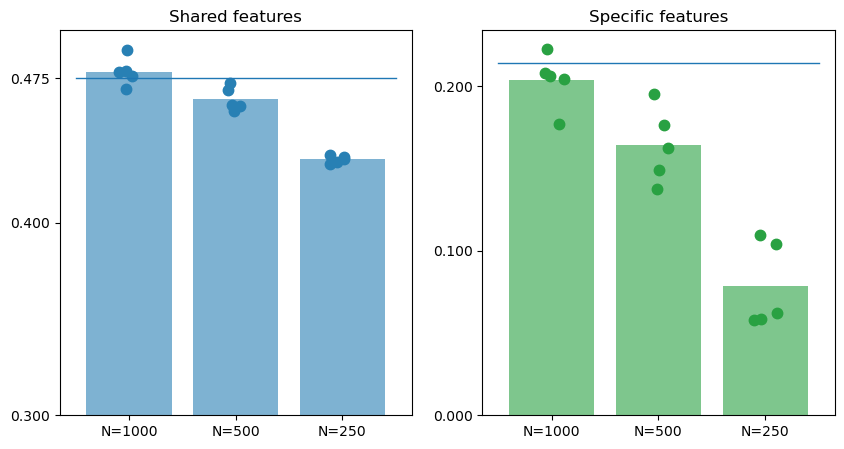

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

#vecs = [res_baseline['rsa_z_m'],res_n500['rsa_z_m'],res_n200['rsa_z_m']]
vecs = [res_repl['rsa_z_m'],res_n500['rsa_z_m'],res_n200['rsa_z_m']]
for i in range(len(vecs)):
    #vec = res_baseline['rsa_s_m']
    vec = vecs[i]
    x = i
    randshift = x+(np.random.rand(5)-.5)*.25
    
    plt.bar(x,vec.mean(),alpha=.6,color=np.array([40,128,180])/255);
    plt.plot(randshift,vec,'.',markersize=15,color=np.array([40,128,180])/255)
    plt.xticks(np.arange(3),['N=1000','N=500','N=250'])
    plt.ylim(.3,.5)
    plt.yticks([.3,.4,.475])

plt.plot([-.5,2.5],[res_baseline['rsa_z_m'].mean(),res_baseline['rsa_z_m'].mean()],linewidth=1)
plt.title('Shared features')

plt.subplot(1,2,2)
#plt.figure(figsize=(5,5))
#vecs = [res_baseline['rsa_s_m'],res_n500['rsa_s_m'],res_n200['rsa_s_m']]
vecs = [res_repl['rsa_s_m'],res_n500['rsa_s_m'],res_n200['rsa_s_m']]
for i in range(len(vecs)):
    #vec = res_baseline['rsa_s_m']
    vec = vecs[i]
    x = i
    randshift = x+(np.random.rand(5)-.5)*.25
    
    plt.bar(x,vec.mean(),alpha=.6,color=np.array([41,161,66])/255);
    plt.plot(randshift,vec,'.',markersize=15,color=np.array([41,161,66])/255)
    plt.xticks(np.arange(3),['N=1000','N=500','N=250'])
    plt.yticks([.0,.1,.2],labels=['0.000','0.100','0.200'])
plt.plot([-.5,2.5],[res_baseline['rsa_s_m'].mean(),res_baseline['rsa_s_m'].mean()],linewidth=1)
plt.title('Specific features')
#plt.suptitle('Generalization test')